<h1><center> Time Series Analysis on Wind Power Production in US using SES, Holt's Linear Trend, Holt-Winters and ARIMA Models

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
# Loading dataset into the df
df = pd.read_csv('wind-power-production-us.csv', index_col='date', parse_dates=True)

In [3]:
# Checking the data
df.head()

,other_united_states,other_new_england,other_connecticut,other_maine,other_massachusetts,other_new_hampshire,other_rhode_island,other_vermont,other_middle_atlantic,other_new_jersey,...,wind_new_mexico,wind_utah,wind_wyoming,wind_pacific_contiguous,wind_california,wind_oregon,wind_washington,wind_pacific_noncontiguous,wind_alaska,wind_hawaii
date,,,,,,,,,,,,,,,,,,,,,
2001-01-01,6025,678,75,348,113,91,10,42,371,66,...,--,--,26,137,133,3,--,0,0,0
2001-02-01,5310,599,77,293,103,83,9,35,338,59,...,--,--,23,151,148,3,--,0,0,0
2001-03-01,5795,660,96,327,101,93,9,33,381,73,...,--,--,22,308,300,8,--,0,0,0
2001-04-01,5827,593,92,277,106,81,9,27,361,66,...,--,--,13,399,393,6,--,0,0,0
2001-05-01,5738,640,72,336,109,86,9,27,392,73,...,--,--,16,383,378,6,--,0,0,0


Note - The unit is `thousand MWh`

In [4]:
# Renaming index as "Month" 
df.index.name = 'Month'

# We are only interested in total wind power production in US, so we will only grab this column
df = df[['wind_united_states']]

# Renaming "wind_united_states" to "Wind" for simplicity
df = df.rename(columns={"wind_united_states": "Wind"})

In [5]:
# Confirming the changes
df.head()

,Wind
Month,
2001-01-01,389
2001-02-01,431
2001-03-01,532
2001-04-01,685
2001-05-01,635


In [6]:
# Check for missing values
df.isna().sum()

Wind    0
dtype: int64

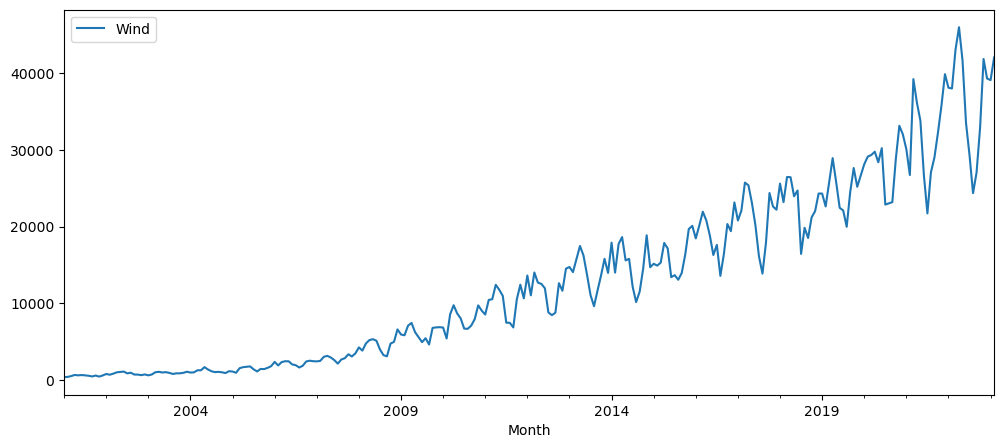

In [7]:
# Plotting the df
df.plot(figsize=(12,5));

------------------------

## SES Model

In [8]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [9]:
# Applying "SES" for Wind column  
ses = SimpleExpSmoothing(df['Wind'])

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Investigating the above warnings

In [10]:
# Calling the index for df
df.index

DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01',
               ...
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
               '2023-01-01', '2023-02-01'],
              dtype='datetime64[ns]', name='Month', length=266, freq=None)

Notice "freq=None". Hence we get the above warning.

In [11]:
# Fixing the freq
df.index.freq = 'MS'    # MS - Months 

In [12]:
# We also include "initialization_method" parameter to fix the warning 
ses = SimpleExpSmoothing(
    df['Wind'],
    initialization_method='legacy-heuristic')  # initializes the moving average just like in the old versions

We no longer get the above warnings when well call ses now.

In [13]:
alpha = 0.2

In [14]:
# Calling ".fit()" function on our model
res = ses.fit(smoothing_level=alpha, optimized=False) 

# when "optimized=False" we manually need to provide the alpha value. 
# If set to "True", which is default the statsmodels will automatically find the optimized value for alpha.

In [15]:
# Printing "res" to see what we are working with (i.e., which class?)
res

In [16]:
# Calling the .predict() function on our results (i.e. res) object
res.predict(start=df.index[0], end=df.index[-1])

Month
2001-01-01      389.000000
2001-02-01      389.000000
2001-03-01      397.400000
2001-04-01      424.320000
2001-05-01      476.456000
                  ...     
2022-10-01    32403.575800
2022-11-01    32487.660640
2022-12-01    34355.328512
2023-01-01    35340.662809
2023-02-01    36087.730248
Freq: MS, Length: 266, dtype: float64

Since we want the predictions for our entire dataset, we are going to pass in the "start" date as the 1st row index of our df and "end" date as the last row index of our df.

In [17]:
# Calling .predict() function again, but assigning it ot a new column called "SES"
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

In [18]:
# Checking the df to confirm the new column
df

,Wind,SES
Month,,
2001-01-01,389,389.000000
2001-02-01,431,389.000000
2001-03-01,532,397.400000
2001-04-01,685,424.320000
2001-05-01,635,476.456000
...,...,...
2022-10-01,32824,32403.575800
2022-11-01,41826,32487.660640
2022-12-01,39282,34355.328512


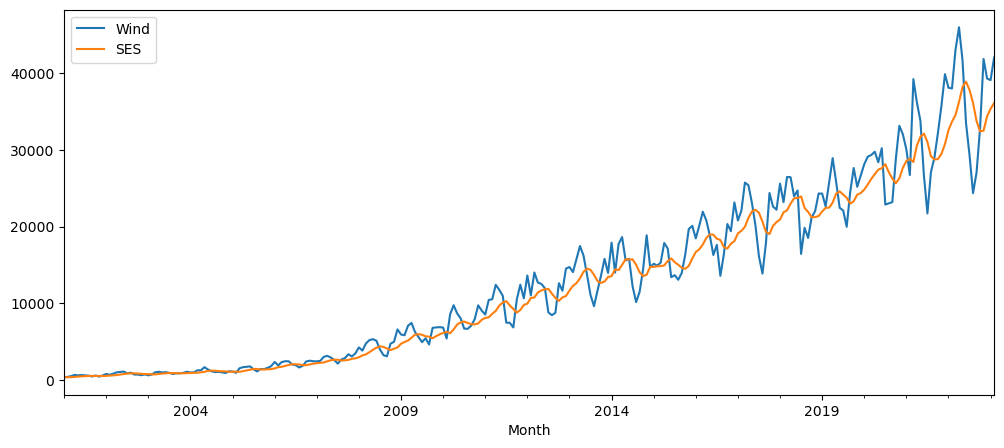

In [19]:
# Plotting the SES model on our data
df.plot(figsize=(12, 5));

#### Treating this problem like an ML problem

In [20]:
# Splitting the df into "train" and "test" sets
Ntest = 12    # Number of rows we set to test data
train  = df.iloc[:-Ntest]
test   = df.iloc[-Ntest:]

In [21]:
# Recreating the "SES" object, but this time with only the "train" set
ses = SimpleExpSmoothing(
    train['Wind'],
    initialization_method='legacy-heuristic')

# Calling the fit() function without passing "alpha" or "optimized" parameters
res = ses.fit() 

In [22]:
# Creating indexes to our df for both train and test sets (for faster computation)

# Boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [23]:
# JFR - Just for Reference
train_idx

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [24]:
# JFR
print(type(train))
print(type(train_idx))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [25]:
# Assigning the predictions from our model back to the original df
df.loc[train_idx, 'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(Ntest)

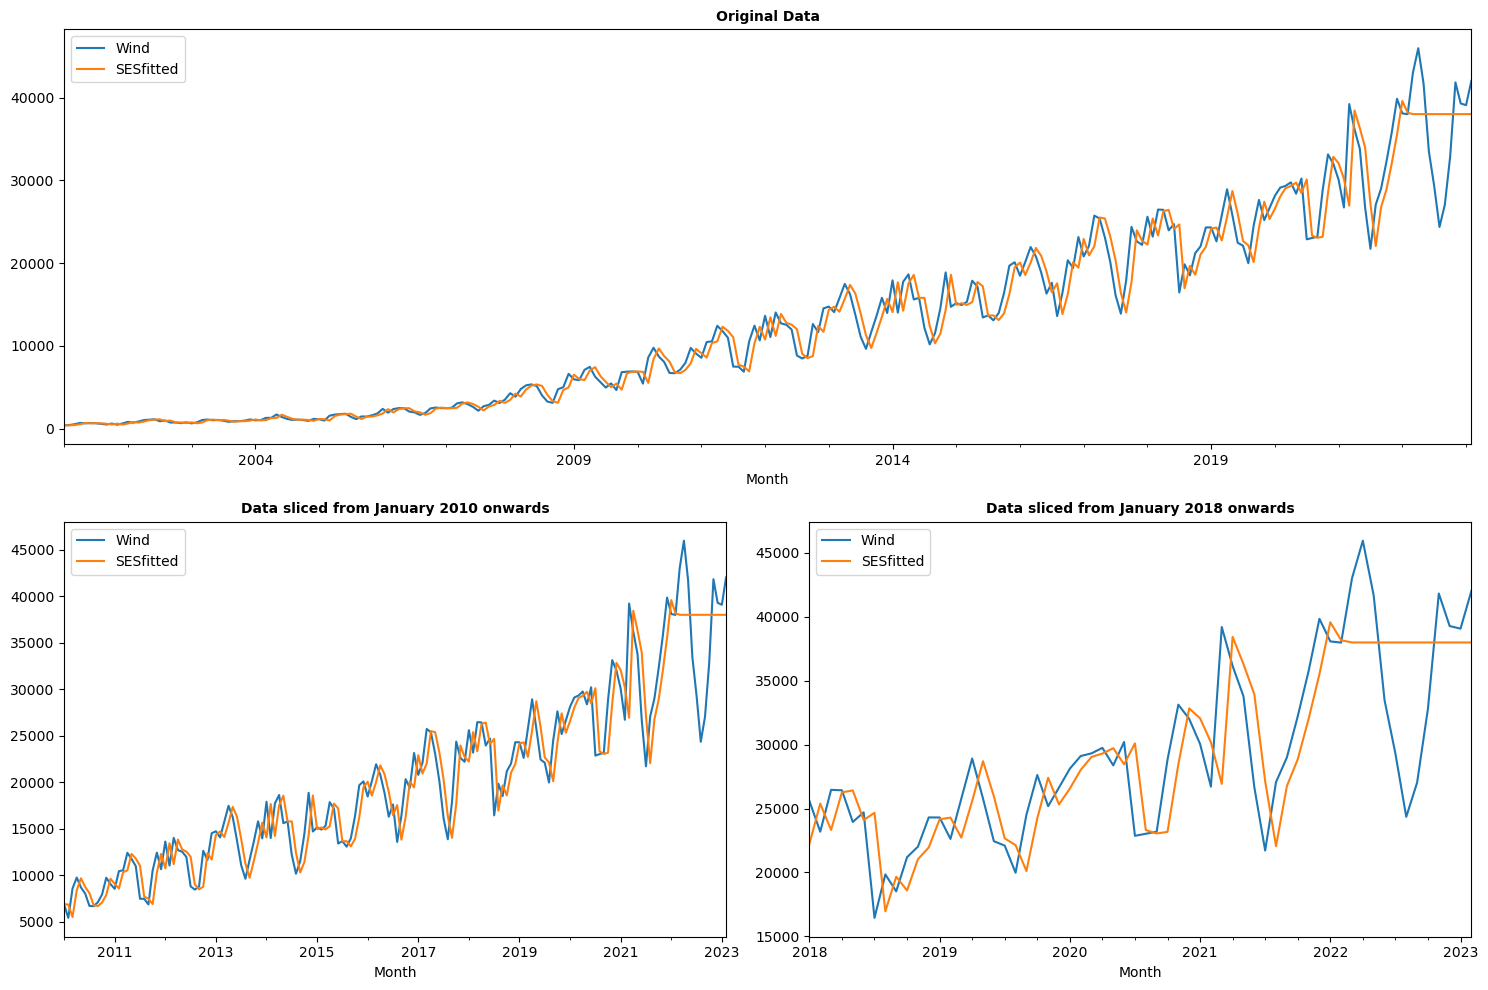

In [26]:
# Plotting the data

# Creating a grid of subplots
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 4, height_ratios=[1,1], width_ratios=[1,1,1,1])

# Add subplots to the GridSpec object
ax1 = fig.add_subplot(gs[0, 0:4])
ax2 = fig.add_subplot(gs[1, 0:2])
ax3 = fig.add_subplot(gs[1, 2:4])

# Plot 1: Original Data
df[['Wind', 'SESfitted']].plot(ax=ax1)
ax1.set_title("Original Data", fontsize=10, fontweight='bold')

# Plot 2: Data sliced from January 2010 onwards
df_sliced = df.loc['2010-01-01':]
df_sliced[['Wind', 'SESfitted']].plot(ax=ax2)
ax2.set_title("Data sliced from January 2010 onwards", fontsize=10, fontweight='bold')

# Plot 3: Data sliced from January 2018 onwards
df_sliced = df.loc['2018-01-01':]
df_sliced[['Wind', 'SESfitted']].plot(ax=ax3)
ax3.set_title("Data sliced from January 2018 onwards", fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

As we can see, the forecast is a horizontal straight line and has a better fit when compared to setting alpha manually.

In [27]:
# Checking the value of alpha
res.params

{'smoothing_level': 0.9374418604651162,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 389.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

The result is very nearly 1 (for “smoothing_level” or alpha). This means our fitted model is essentially performing a Naive Forecast. In other words, it simply replicates the last known value in the series.

-------------------------------

## Holt's Linear Trend Model

In [28]:
from statsmodels.tsa.holtwinters import Holt

In [29]:
# Passing our df in Holt's object
holt = Holt(
    df['Wind'],
    initialization_method='legacy-heuristic')

In [30]:
# Calling .fit() function to fit our model
res_h = holt.fit()

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [31]:
# Assigning the fitted values to the Holt column in our df
df['Holt'] = res_h.fittedvalues

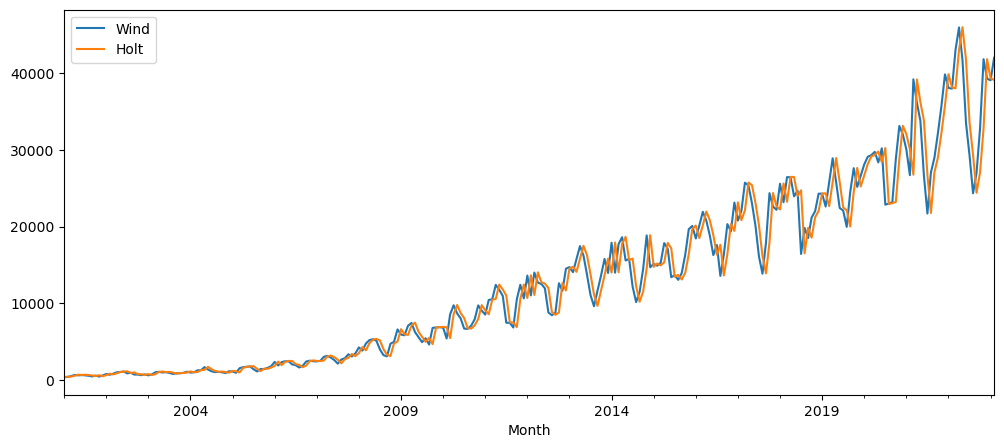

In [32]:
# Plotting the Holt column along with the original TS (i.e,. 'Wind' column)
df[['Wind', 'Holt']].plot(figsize=(12,5));

As we can see, this is similar to the previous model where all it does is seem to track the previous value.

The next step is to use our train-test split again so we can do a real forecast.

In [33]:
# Creating a new Holt's object and passing in the train set
holt = Holt(train['Wind'], initialization_method='legacy-heuristic')
# Calling .fit() function with no arguments
res_h = holt.fit()
# Assigning the fitted values to our df for the rows corresponding to the train set
df.loc[train_idx, 'Holt'] = res_h.fittedvalues

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [34]:
# Calling forecast for Ntest time steps and then assigning the result to our df for the rows corresponding to the test set
df.loc[test_idx, 'Holt'] = res_h.forecast(Ntest)

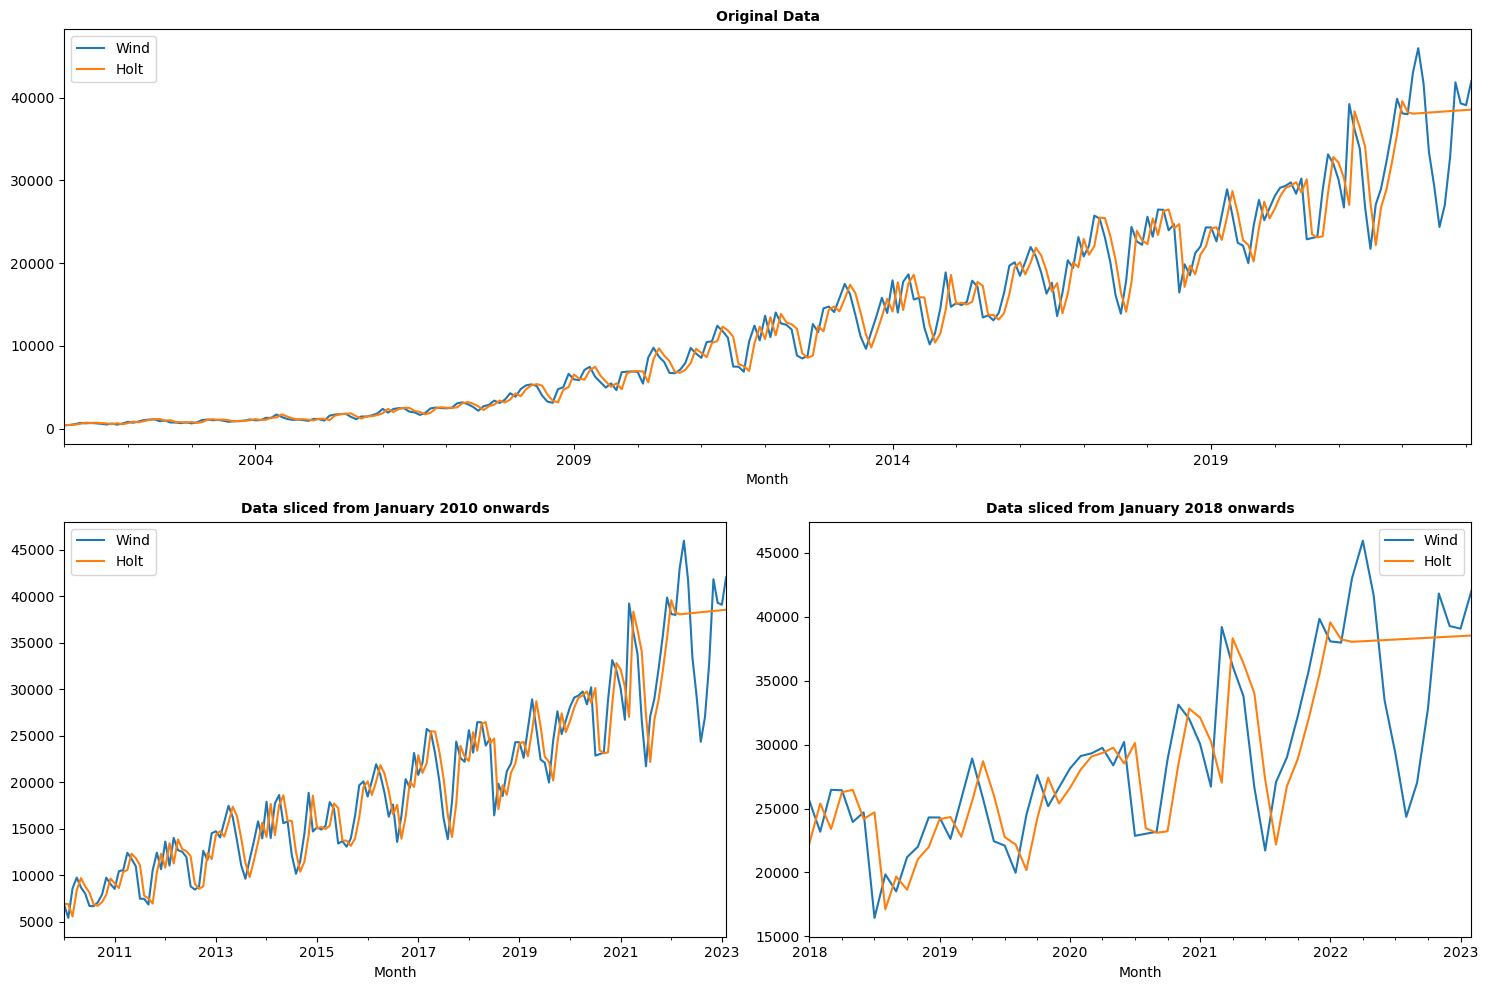

In [35]:
# Plotting the data

# Creating a grid of subplots
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 4, height_ratios=[1,1], width_ratios=[1,1,1,1])

# Adding subplots to the GridSpec object
ax1 = fig.add_subplot(gs[0, 0:4])
ax2 = fig.add_subplot(gs[1, 0:2])
ax3 = fig.add_subplot(gs[1, 2:4])

# Plot 1: Original Data
df[['Wind', 'Holt']].plot(ax=ax1)
ax1.set_title("Original Data", fontsize=10, fontweight='bold')

# Plot 2: Data sliced from January 2010 onwards
df_sliced = df.loc['2010-01-01':]
df_sliced[['Wind', 'Holt']].plot(ax=ax2)
ax2.set_title("Data sliced from January 2010 onwards", fontsize=10, fontweight='bold')

# Plot 3: Data sliced from January 2018 onwards
df_sliced = df.loc['2018-01-01':]
df_sliced[['Wind', 'Holt']].plot(ax=ax3)
ax3.set_title("Data sliced from January 2018 onwards", fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

We still seem to get a straight line, just like the previous ones. The line does seem to be trending slightly upwards.

------------------------

## Holt-Winters Model

In [36]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#### Fitting all possible models 

In [37]:
# 1. All Additive Holt-Winters Model

# Creating an instance of our model. 
# Calling the train-test split rather than fitting a model to the entire dataset.
# Trying "Additive" model only first and then calling the .fit() function.
hw1 = ExponentialSmoothing(
    train['Wind'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='add', seasonal_periods=12)
res_hw1 = hw1.fit()

# Assigning the fitted values to "HoltWinters1" column of our original df for the train rows.
df.loc[train_idx, 'HoltWinters1'] = res_hw1.fittedvalues
# Calling the .forecast() function for Ntest steps and assigning the results to our original df for the test rows.
df.loc[test_idx, 'HoltWinters1'] = res_hw1.forecast(Ntest)

# -------------------------------------------------------------------

# 2. Additive Trend - Multiplicative Seasonality
hw2 = ExponentialSmoothing(
    train['Wind'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='mul', seasonal_periods=12)
res_hw2 = hw2.fit()

df.loc[train_idx, 'HoltWinters2'] = res_hw2.fittedvalues
df.loc[test_idx, 'HoltWinters2'] = res_hw2.forecast(Ntest)

# -------------------------------------------------------------------

# 3. Multiplicative Trend - Additive Seasonality
hw3 = ExponentialSmoothing(
    train['Wind'],
    initialization_method='legacy-heuristic',
    trend='mul', seasonal='add', seasonal_periods=12)
res_hw3 = hw3.fit()

df.loc[train_idx, 'HoltWinters3'] = res_hw3.fittedvalues
df.loc[test_idx, 'HoltWinters3'] = res_hw3.forecast(Ntest)

# -------------------------------------------------------------------

# 4. All Multiplicative Model 
hw4 = ExponentialSmoothing(
    train['Wind'],
    initialization_method='legacy-heuristic',
    trend='mul', seasonal='mul', seasonal_periods=12)
res_hw4 = hw4.fit()

df.loc[train_idx, 'HoltWinters4'] = res_hw4.fittedvalues
df.loc[test_idx, 'HoltWinters4'] = res_hw4.forecast(Ntest)

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Plotting all the models

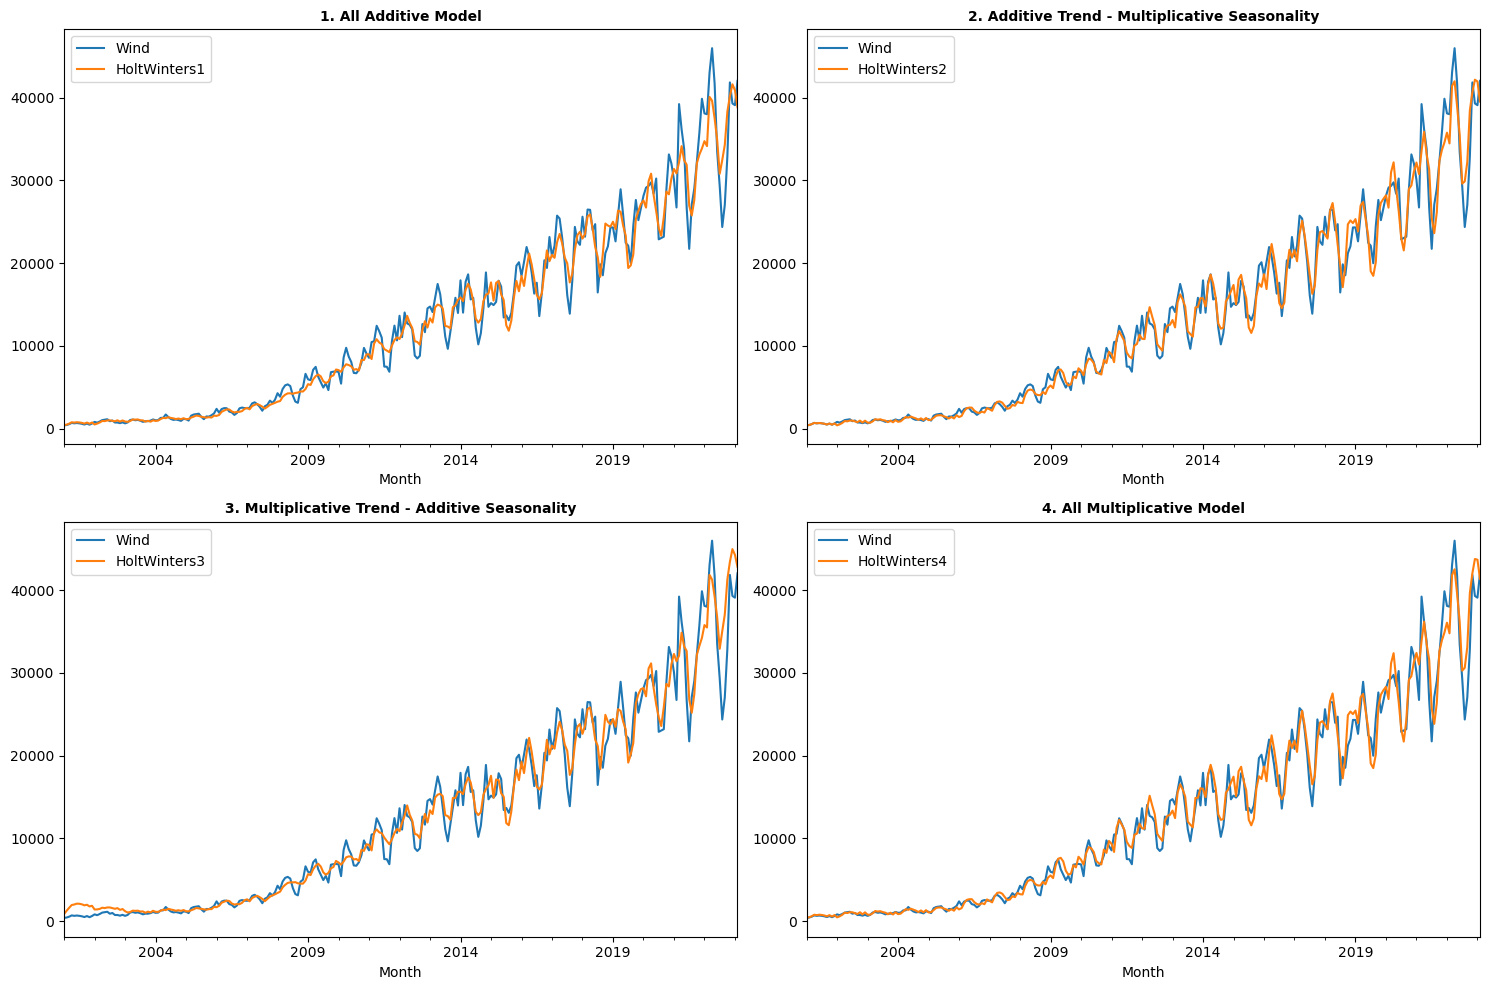

In [38]:
# Creating a grid of subplots
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1,1], width_ratios=[1,1])

# Adding subplots to the GridSpec object
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Plot 1: All Additive Model
df[['Wind', 'HoltWinters1']].plot(ax=ax1)
ax1.set_title("1. All Additive Model", fontsize=10, fontweight='bold')

# Plot 2: Additive Trend - Multiplicative Seasonality
df[['Wind', 'HoltWinters2']].plot(ax=ax2)
ax2.set_title("2. Additive Trend - Multiplicative Seasonality", fontsize=10, fontweight='bold')

# Plot 3: Multiplicative Trend - Additive Seasonality
df[['Wind', 'HoltWinters3']].plot(ax=ax3)
ax3.set_title("3. Multiplicative Trend - Additive Seasonality", fontsize=10, fontweight='bold')

# Plot 4: All Multiplicative Model
df[['Wind', 'HoltWinters4']].plot(ax=ax4)
ax4.set_title("4. All Multiplicative Model", fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

From the above plots, Plot 2 and Plot 4 seem to do a much better job. However, it’s hard to distinguish which one is better among these two.

Let’s calculate RMSE to see which model performs better.

In [39]:
# Calculating RMSE
def rmse(y, t):
  return np.sqrt(np.mean((y - t)**2))

# Checking the RMSE in both the train and test sets for all the models
print("1. All Additive Model:")
print("Train RMSE:", rmse(train['Wind'], res_hw1.fittedvalues))
print("Test RMSE :", rmse(test['Wind'], res_hw1.forecast(Ntest)),"\n")

print("2. Additive Trend - Multiplicative Seasonality:")
print("Train RMSE:", rmse(train['Wind'], res_hw2.fittedvalues))
print("Test RMSE :", rmse(test['Wind'], res_hw2.forecast(Ntest)),"\n")

print("3. Multiplicative Trend - Additive Seasonality:")
print("Train RMSE:", rmse(train['Wind'], res_hw3.fittedvalues))
print("Test RMSE :", rmse(test['Wind'], res_hw3.forecast(Ntest)),"\n")

print("4. All Multiplicative Model:")
print("Train RMSE:", rmse(train['Wind'], res_hw4.fittedvalues))
print("Test RMSE :", rmse(test['Wind'], res_hw4.forecast(Ntest)))

1. All Additive Model:
Train RMSE: 1588.2399231378117
Test RMSE : 4469.1278816364165 

2. Additive Trend - Multiplicative Seasonality:
Train RMSE: 1459.0816801160245
Test RMSE : 3453.2733402389554 

3. Multiplicative Trend - Additive Seasonality:
Train RMSE: 1634.9218103364187
Test RMSE : 5773.450352805581 

4. All Multiplicative Model:
Train RMSE: 1465.2860073272236
Test RMSE : 3978.777967209359


Firstly, the Test RMSE is higher than the Train RMSE, indicating that the model doesn’t generalize well to unseen data and might be overfitting the training data.

The Test RMSE for the second model, which uses an Additive Trend and Multiplicative Seasonality, is the lowest among all other models. This suggests that it is the best model for forecasting this time series data. This is likely because this model accounts for both the trend and seasonal components of the data, which are significant in this case. The other models, such as the Simple Exponential Smoothing (SES) model and the Holt's Linear Trend Method, are not as well-suited for forecasting data with both trend and seasonality.

The RMSE for the Test model is found to be 3453.27. To determine if this is a good model, let’s calculate the mean and standard deviation.

In [40]:
# Calculating and printing mean and std dev for the data
print("Mean   :",df.Wind.mean())
print("Std Dev:",np.sqrt(df.Wind.var()))

Mean   : 12888.214285714286
Std Dev: 11305.680657083241


Considering that the Test RMSE (3453.27) is significantly lower than both the mean (12888.21) and standard deviation (11305.68), it suggests that the model’s predictions are reasonably close to the actual values, despite its inability to generalize well to unseen data.

The mean and standard deviation of the data are both significantly higher than the Test RMSE, suggesting that the model is able to capture the overall level and trend of the data. However, the Test RMSE is still relatively high. This could suggest (as one possible interpretation) that the model is having some difficulty forecasting the seasonal component.

-------------------

## ARIMA 

In [41]:
# Dropping unwanted columns 
df.drop(['SES', 'SESfitted', 'Holt', 'HoltWinters1', 'HoltWinters2', 'HoltWinters3', 'HoltWinters4'], axis=1, inplace=True )

In [42]:
df.head()

,Wind
Month,
2001-01-01,389
2001-02-01,431
2001-03-01,532
2001-04-01,685
2001-05-01,635


In [43]:
# JFR
train.head()

,Wind,SES
Month,,
2001-01-01,389,389.000
2001-02-01,431,389.000
2001-03-01,532,397.400
2001-04-01,685,424.320
2001-05-01,635,476.456


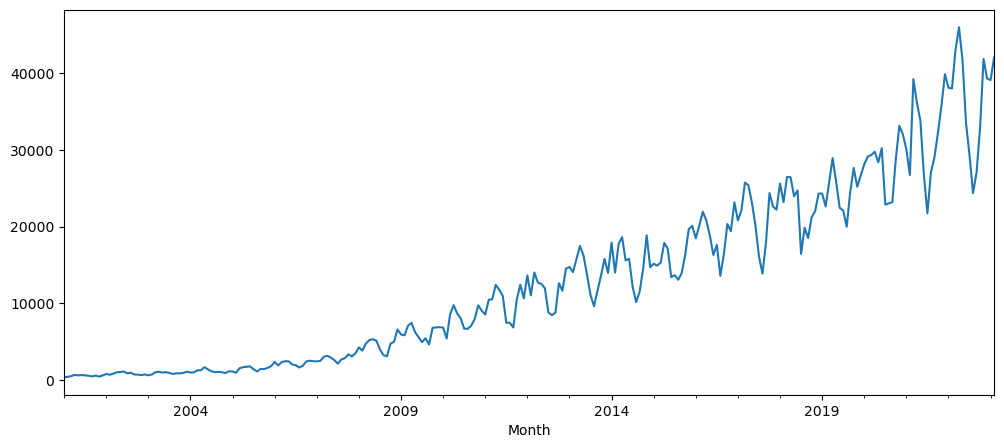

In [44]:
# Plotting the data to see what it looks like
df['Wind'].plot(figsize=(12,5));

There is a pretty strong seasonal componenet and the amplitude of the cycles seems to grow over time.

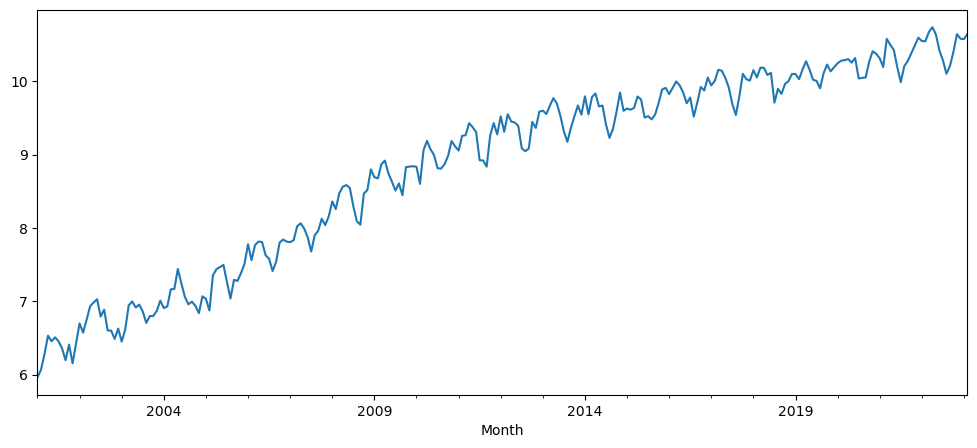

In [45]:
# Computing and plotting the log transform
df['LogWind'] = np.log(df['Wind'])
df['LogWind'].plot(figsize=(12,5));

Its better than the above graph, but still the data is not stationary.

In [46]:
# Setting our index frequency to Months
df.index.freq = 'MS'

In [47]:
# Splitting our data into train and test sets
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [48]:
# JFR
train.head()

,Wind,LogWind
Month,,
2001-01-01,389,5.963579
2001-02-01,431,6.066108
2001-03-01,532,6.276643
2001-04-01,685,6.529419
2001-05-01,635,6.453625


In [49]:
# Creating indexes to our df for both train and test sets (for faster computation)

# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

### Choosing ARIMA model manually using ACF & PACF

#### Checking for Stationarity

In [50]:
# Differncing our data
df1 = df['Wind'].diff()

In [51]:
# JFR
print(df1)

Month
2001-01-01       NaN
2001-02-01      42.0
2001-03-01     101.0
2001-04-01     153.0
2001-05-01     -50.0
               ...  
2022-10-01    5792.0
2022-11-01    9002.0
2022-12-01   -2544.0
2023-01-01    -206.0
2023-02-01    2939.0
Freq: MS, Name: Wind, Length: 266, dtype: float64


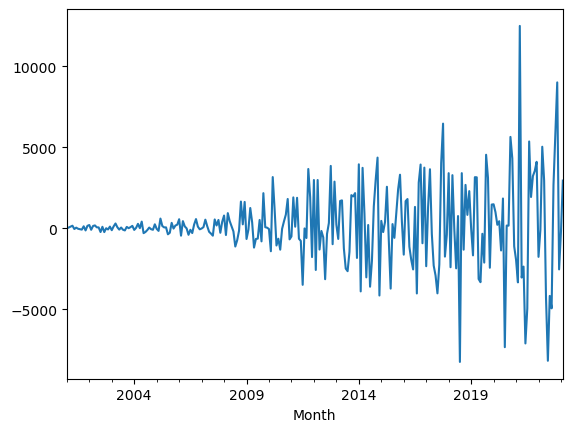

In [52]:
df1.plot();

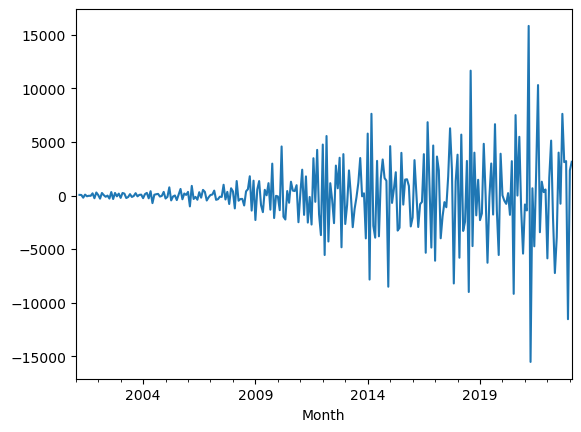

In [53]:
# Differencing the data for a 2nd time
df2 = df1.diff().plot();

Checking stationarity for logged data since the regular data is still not satationary, even after differencing twice. 

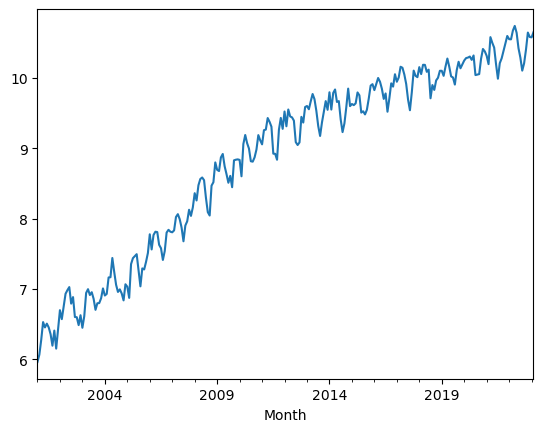

In [54]:
# Plotting the LogWind data
df['LogWind'].plot();

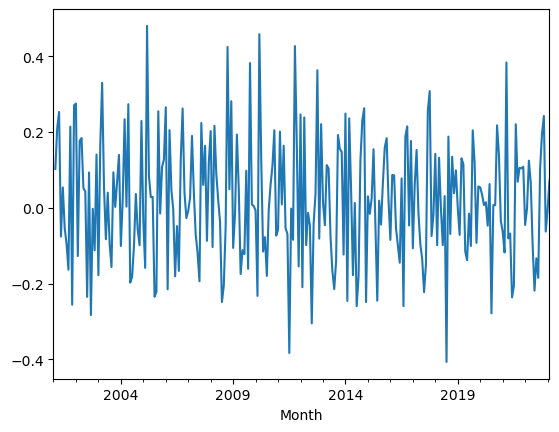

In [55]:
# Differencing the LogWind data
df['LogWind'].diff().plot();

Finally, our data is stationary.

#### Confirming Stationarity by performing ADF test

In [56]:
from statsmodels.tsa.stattools import adfuller

In [57]:
# Running ADF on Log Sales
adfuller(df['LogWind'])

(-2.21668527306138,
 0.200245493486628,
 15,
 250,
 {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544},
 -330.1561651510183)

Since, P-Value is 0.20, we would not reject the null-hypothesis. Therefore, we would not say that this Time Series is stationary.

In [58]:
# Trying the ADF on difference in Log Sales
adfuller(df['LogWind'].diff().dropna())

(-4.068445879744024,
 0.0010916074241727946,
 14,
 250,
 {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544},
 -325.6542367395947)

We would say that this Time Series is stationary since the P-Value is below 5%. 

#### Plotting ACF and PACF

In [59]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

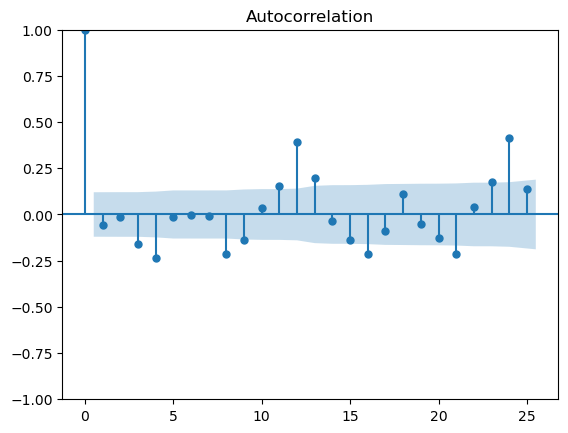

In [60]:
# Plotting the ACF with the "difference" in log of Wind
plot_acf(df['LogWind'].diff().dropna());

We see that there are significant lags at 12 and 24 for q. Ideally "q" should be lower.

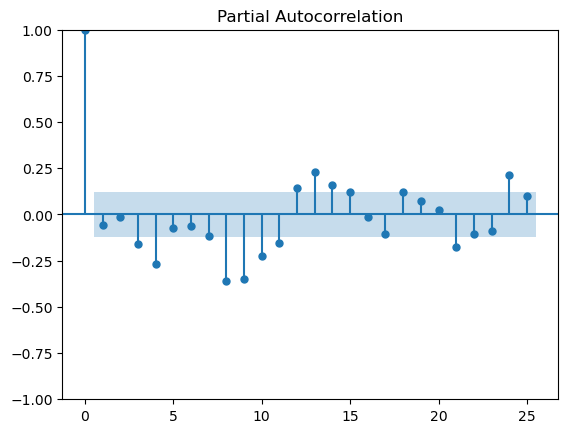

In [61]:
# Plotting PACF
plot_pacf(df['LogWind'].diff().dropna(), method='ols'); 

# With the default method, we get an invalid answer. Hence, we set the method to ‘ols’, which seems to fix the problem.

We see that there are significant lags at 13 and 24. But since we want our model to be parsimonious we'll go with `p=13`.

#### Forecasting our ARIMA model based on ACF and PACF plots

In [62]:
# Writing a function to plot ARIMA forecast

def plot_fit_and_forecast(result, d=1, col='Wind'):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df[col], label='data')

    # plot the curve fitted on train set
    train_pred = result.fittedvalues
    ax.plot(train.index[d:], train_pred[d:], color='green', label='fitted')

    # forecast the test set
    prediction_result = result.get_forecast(Ntest)
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int[f'lower {col}'], conf_int[f'upper {col}']
    forecast = prediction_result.predicted_mean
    ax.plot(test.index, forecast, label='forecast')
    ax.fill_between(test.index, \
                    lower, upper, \
                    color='red', alpha=0.3)
    ax.legend()

    return forecast

From the PACF plot, we know that p=13, and we’ve differenced the data once, so d=1. Ideally, q should be lower, but we’ll still test different values of q (i.e., 24,12,2,1,0) and see how the forecast fits.

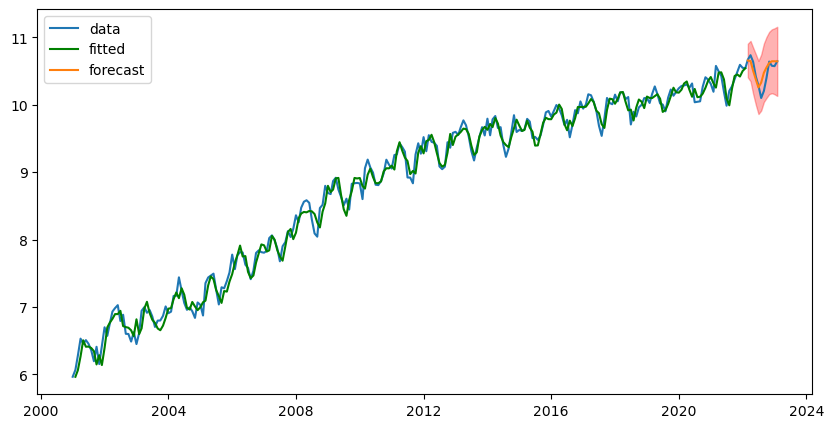

In [63]:
# Training our ARIMA model using the parameters suggested by the plots we just saw
arima = ARIMA(train['LogWind'], order=(13,1,0))  

# We fit our ARIMA model to a variable called "arima_result"
arima_result = arima.fit()

# We plot our forecast
forecast = plot_fit_and_forecast(arima_result, col='LogWind')

We tested different values of q and the MAPE for those values were as follows:

q=24, order=(13,1,24) - 10.25%   
q=12, order=(13,1,12) - 12.26%   
q=2, order=(13,1,2) - 11.24%   
q=1, order=(13,1,1) - 11.23%   
q=0, order=(13,1,0) - 9.95%  

From the MAPE values, it’s clear that q=0 gives us the best results and also keeps the model parsimonious. Judging by the above q values, we can clearly see that higher-order q values overfit the model.

In [64]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [65]:
# Computing MAPE using ACF and PACF plots        # (13,1,0)
print("MAPE for ARIMA model (13,1,0) is :", round((MAPE(test['Wind'], np.exp(forecast)) * 100),2),"%")

MAPE for ARIMA model (13,1,0) is : 9.95 %


In [66]:
# JFR - Train MAPE for ARIMA(13,1,0) - We'll need this for reference in the below analysis
print(" Train MAPE for ARIMA model (13,1,0) is :", round((MAPE(train['Wind'][1:], np.exp(arima_result.fittedvalues)[1:]) * 100),2),"%")

 Train MAPE for ARIMA model (13,1,0) is : 10.17 %


### Checking for best Non-Seasonal Model

In [67]:
import pmdarima as pm

In [68]:
# Best non-seasonal model
model = pm.auto_arima(train['LogWind'],
                      trace=True,
                      max_p=13, max_q=2, max_order=15,
                      suppress_warnings=True,
                      stepwise=False,  # Full grid search
                      seasonal=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-200.850, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-200.376, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-199.628, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-200.298, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-225.043, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-225.260, Time=0.45 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-198.352, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-226.808, Time=0.37 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-253.065, Time=0.64 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-202.531, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-238.259, Time=0.46 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-244.906, Time=0.58 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-219.578, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-240.906, Time=0.44 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-239.829, Time=0.58 sec
 ARIMA(5,1

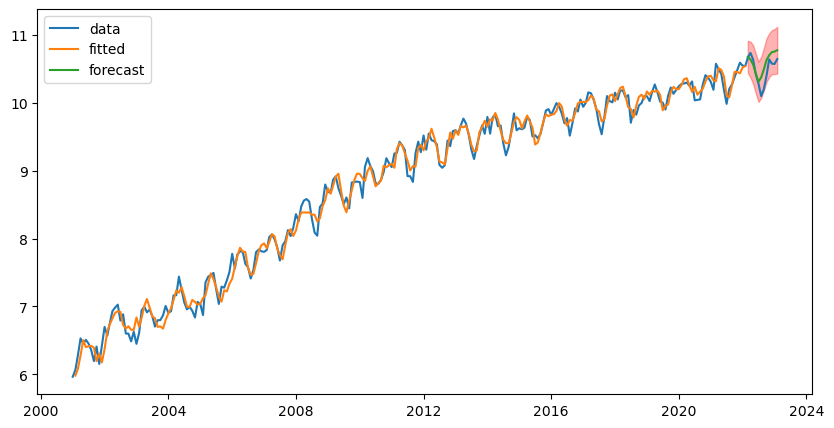

In [69]:
# Plotting our predictions
train_pred = model.predict_in_sample(start=1, end=-1)
test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df['LogWind'], label='data')
ax.plot(train.index[1:], train_pred, label='fitted')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)
ax.legend();

Our predictions are pretty close, as we might expect.

In [70]:
# Computing MAPE for non-seasonal model (12,1,2)
print("MAPE for best non-seasonal model is :", round((MAPE(test['Wind'], np.exp(test_pred)) * 100),2),"%")

MAPE for best non-seasonal model is : 14.29 %


Now, this seems odd, as the AIC for ARIMA(12,1,2) is -312.577 and is lower compared to ARIMA(13,1,0), which has an AIC of about -309.412. Yet, the MAPE suggests that ARIMA(13,1,0) is a better model.

This is because our AIC values are based on training data only, whereas our MAPE values are based on test predictions. So, this tells us that ARIMA(12,1,2) is probably overfitting the training data, resulting in a higher test MAPE.

Calculting training MAPE for better understanding

In [71]:
# Computing train MAPE for ARIMA(12,1,2) for confirmation
print("Train MAPE for best non-seasonal model is :", round((MAPE(train['Wind'][1:], np.exp(train_pred)) * 100),2),"%")

Train MAPE for best non-seasonal model is : 9.78 %


We can see that the training MAPE is lower for ARIMA(12,1,2), which is 9.78%, compared to ARIMA(13,1,0), which we calculated previously to be about 10.17%. This confirms our suspicions that the latter ARIMA model is overfitting the training data, resulting in a higher MAPE.

This indicates that ARIMA(13,1,0) is a better model compared to ARIMA(12,1,2).

### Checking for best Seasonal Model

In [72]:
# Running Auto ARIMA on the LogWind data
model = pm.auto_arima(train['LogWind'],
                      trace=True,
                      suppress_warnings=True,
                      seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-334.367, Time=2.13 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-200.850, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-264.255, Time=0.44 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-233.044, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-199.686, Time=0.06 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-253.524, Time=1.29 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-287.413, Time=1.18 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-338.229, Time=3.58 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-328.299, Time=3.30 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=-339.638, Time=3.95 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-336.537, Time=1.80 sec
 ARIMA(1,1,2)(2,0,2)[12] intercept   : AIC=-338.816, Time=1.94 sec
 ARIMA(2,1,1)(2,0,2)[12] intercept   : AIC=-332.522, Time=2.13 sec
 ARIMA(3,1,2)(2,0,2)[12] intercept   : AIC=-338.636, Time=2.52 sec
 ARIMA(2,1,3)(2,0,2

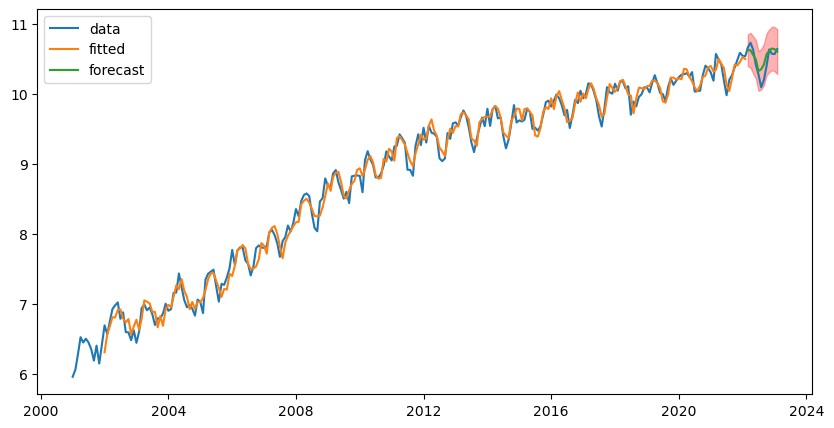

In [73]:
# Plotting in-sample and out-of-sample predictions

# Since the model is seasonal, we won't plot or predict the first 12 values (since pmdarima will set them to 0)
train_pred = model.predict_in_sample(start=12, end=-1)
test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df['LogWind'], label='data')
ax.plot(train.index[12:], train_pred, label='fitted')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)
ax.legend();

Again, our predictions match pretty closely with our Time Series. In fact, they look quite similar to our previous predictions.

In [74]:
# Computing MAPE for non-seasonal model (0,1,4)(2,0,1)[12]
print("MAPE for best seasonal model is :", round((MAPE(test['Wind'], np.exp(test_pred)) * 100),2),"%")

MAPE for best seasonal model is : 10.63 %


The sesonal model is better than non-seasonal model and is slightly worse than ARIMA(13,1,0) that we forecasted using ACF and PACF plots as reference. 